In [1]:
! pip install geopandas -q
! pip install --upgrade xgboost -q
! pip install --upgrade mapclassify -q
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from shapely.geometry import shape
import json
import folium
from sklearn.metrics import r2_score

# connect to drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

     |████████████████████████████████| 1.0 MB 14.0 MB/s 
     |████████████████████████████████| 16.7 MB 271 kB/s 
     |████████████████████████████████| 6.3 MB 42.0 MB/s 
     |████████████████████████████████| 192.9 MB 81 kB/s 
Mounted at /content/drive


Load in various data sources to reference later:

In [2]:
# IMERG data to be eventually be used for modeling...
# Has rainfall but missing basin characteristics
gdf = gpd.read_file((
'/content/drive/My Drive/staley_basins_w_imerg_redo_20pct_thresh_w_RI.geojson'))

# Data for Beechworth DF
aus_ts = gpd.read_file('/content/drive/My Drive/aus_beechworth_ts.geojson')

# Original data generated from GEE recording basin characteristics
# Note: Missing rainfall
df = pd.read_csv(
'/content/drive/My Drive/staley_pts_w_basin_comp_redo_20pct_thresh_6mnth_times_redo.csv')

gdf.set_index('PtIndex',inplace=True)
df.set_index('PtIndex',inplace=True)

In [3]:
# Drop areas where Staley et al. had no recorded data
gdf.drop(gdf[gdf['Peak_I30_mm/h']==0].index,inplace=True)

In [4]:
# add in a few missing values from one file to another
# gdf has rainfall but is missing the newly generated burn and slope data.
# add these in for each basin from the file recording these characteristics
def add_properties(row):
  idx = row.name
  df_data = df.loc[idx]
  row['Mean_dNBR'] = df_data['Mean_dNBR']
  row['Mean_dNBR_yr'] = df_data['Mean_dNBR_yr']
  row['SlopeBurnAreaRatio'] = df_data['SlopeBurnAreaRatio']
  row['SlopeBurnAreaRatio_yr'] = df_data['SlopeBurnAreaRatio_yr']
  row['Visibility'] = df_data['Visibility']
  row['Visibility_yr'] = df_data['Visibility_yr']
  row['MedianSlope'] = df_data['MedianSlope']
  row['MeanPropLAI'] = df_data['Mean_dLAI']
  return row

In [5]:
gdf = gdf.apply(add_properties,axis=1)
print(len(gdf))

627


In [6]:
# few other features
gdf['IntensityDiff'] = abs(gdf['MaxVal'] - gdf['Peak_I30_mm/h'])
gdf['SumDiff'] = abs(gdf['SumVal'] - gdf['StormAccum_mm'])
gdf['PropBelowYrMax'] = gdf['MaxVal'] / gdf['RIClosestVal']

The following code blocks are for generating Figure 2 and reporting the results of the Mann-Whitney U test:



In [11]:
cols = ['MaxVal','Peak_I30_mm/h','StormDur_H']
ca = gdf[gdf['Database']=='Training']
ius = gdf[gdf['Database']!='Training']

ca_pos = ca[ca['Response']==1].index
ca_neg = ca[ca['Response']!=1].index
ius_pos = ius[ius['Response']==1].index
ius_neg = ius[ius['Response']!=1].index

In [12]:
# Stats from Mann-Whitney U test:
from scipy.stats import mannwhitneyu

pos = gdf[gdf['Response']==1].index
neg = gdf[gdf['Response']!=1].index

U1, p = mannwhitneyu(gdf.loc[pos,'MaxVal'], gdf.loc[neg,'MaxVal'])
print("p value:",p)

p value: 1.8032332806138384e-15


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

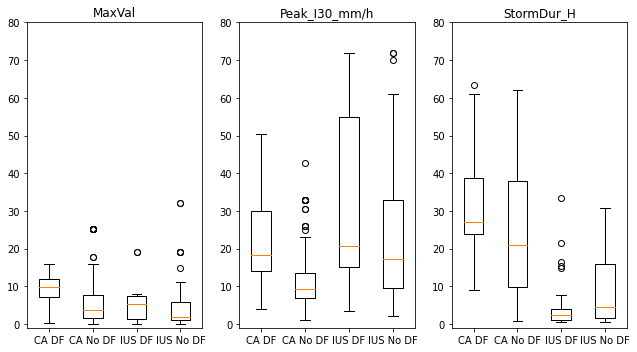

In [13]:
# Fig 2a-c
fig, ax = plt.subplots(1,len(cols),figsize=(9,5))
for i in range(0,len(cols)):
  ax[i].boxplot(x=[ca.loc[ca_pos,cols[i]].dropna(),
                   ca.loc[ca_neg,cols[i]].dropna(),
                   ius.loc[ius_pos,cols[i]].dropna(),
                   ius.loc[ius_neg,cols[i]].dropna()],
                labels=['CA DF','CA No DF','IUS DF','IUS No DF'])
  ax[i].set_title(cols[i])
  ax[i].set_ylim(-1,80)
fig.tight_layout()
plt.savefig('imerg_staley_rain_intensity_comparison.png',dpi=500)
plt.show()

SpearmanrResult(correlation=0.4016824782314079, pvalue=1.1914188160150237e-19)
SpearmanrResult(correlation=0.4074982710720193, pvalue=1.1780582794371678e-07)


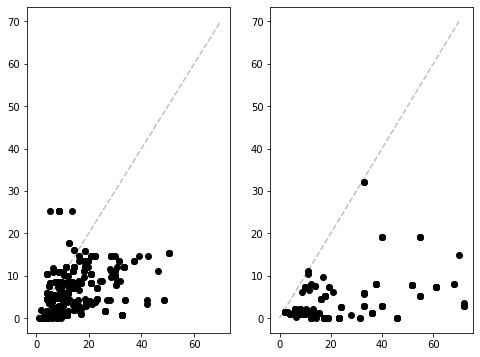

In [14]:
from scipy import stats
fig, ax = plt.subplots(1,2,figsize=(8,6))


ones = np.linspace(0,70,100)
ax[0].scatter(ca['Peak_I30_mm/h'],ca['MaxVal'],c='black',label='CA')
ax[1].scatter(ius['Peak_I30_mm/h'],ius['MaxVal'],c='black',label='IUS',marker='o')
ax[0].plot(ones,ones,color='k',linestyle='--',alpha=0.25)
ax[1].plot(ones,ones,color='k',linestyle='--',alpha=0.25)


print(stats.spearmanr(ca['Peak_I30_mm/h'], ca['MaxVal']))
print(stats.spearmanr(ius['Peak_I30_mm/h'], ius['MaxVal']))

#fig.savefig('figure_2de.png',dpi=400)
plt.show()

In [15]:
# Some areas never get a fully cloud-free mosaic before the storm
# For those, a 6-month mosaic value is used instead

# "Visibility" is the ratio of clear pixels to all available pixels.
# Anything below 95% visibility is replaced with the 6 month value.
# Note: the '_yr' is an artifact of the original variables used in the 
# generating script. These are actually 6 month mosaic values.  
low_vis = gdf[gdf['Visibility']<0.95] 
gdf.loc[low_vis.index,'Mean_dNBR'] = gdf.loc[low_vis.index,'Mean_dNBR_yr']
gdf.loc[low_vis.index,'SlopeburnAreaRatio'] = gdf.loc[low_vis.index,'SlopeBurnAreaRatio_yr']

In [16]:
# Sometimes, no image meets the visibility standard. 
# These are dropped entirely. 
print('Data shape before dropping remaining cloudy areas:', gdf.shape)
gdf.drop(gdf[gdf['Visibility_yr']<0.95].index,inplace=True)
print('Data shape after dropping remaining cloudy areas:', gdf.shape)

Data shape before dropping remaining cloudy areas: (627, 63)
Data shape after dropping remaining cloudy areas: (622, 63)


This the below code blocks are for the generation of the Figure 1a.

In [19]:
# all unique basin area/storm values - don't want any duplicates
# in the summary statistics!
gdf_c = gdf.loc[gdf[['ContributingArea_km2','StormEnd']].drop_duplicates().index]

SpearmanrResult(correlation=0.9984411830084011, pvalue=0.0)


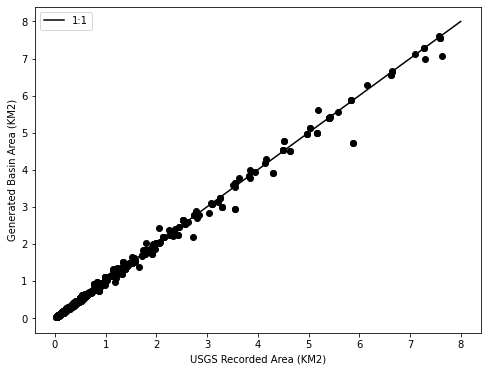

In [21]:
from sklearn.metrics import r2_score

# correlation for manual basin areas and areas reported by staley et al.
print(stats.spearmanr(gdf_c['ContributingArea_km2'], gdf_c['AreaSqKm']))

# Make Fig 1a
plt.figure(figsize=(8,6))
plt.scatter(gdf_c['ContributingArea_km2'],gdf_c['AreaSqKm'],color='k')
plt.xlabel('USGS Recorded Area (KM2)')
plt.ylabel('Generated Basin Area (KM2)')
ones = np.linspace(0,8,100)
plt.plot(ones,ones,label='1:1',color='k')
plt.legend()
plt.show()
#plt.savefig('staley_basin_area_comp.png',dpi=600)

The below code blocks provide a walkthrough of how modeling occured:

In [26]:
# sample cols to use for the model
cols = ['Mean_dNBR','SlopeBurnAreaRatio','MaxVal']
pos = gdf[gdf['Response']==1].index
neg = gdf[gdf['Response']==0].index

In [27]:
features = gdf[cols].drop_duplicates()  
targets = gdf.loc[features.index,'Response']
print(features.shape)

(618, 3)


In [28]:
# Helper Function. Not all of it is being used -- 
# mostly just used for the threat score here
def get_metrics(test_targets, probs):
  fpr, tpr, thresholds = metrics.roc_curve(test_targets, probs, pos_label=1)
  thresholds[0] = thresholds[0]-1

  auc = []
  ts = []
  fps = []
  tps = []
  tns = []
  fns = []
  for thresh in thresholds:
    pred_list = []
    for prob in probs:
      if prob >= thresh:
        pred_list.append(1)
      else:
        pred_list.append(0)
    cm = confusion_matrix(test_targets,pred_list)
    tn, fp, fn, tp = cm.ravel()
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)

    ts.append((tp / (tp+fn+fp)))
    auc.append(roc_auc_score(test_targets, pred_list))
  return fpr, tpr, thresholds, auc, ts, [tns, fps, fns, tps]

In [29]:
# import ml libraries, do training! 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10,
     random_state=0)

tss = []
aucs = []
auc2 = []
thresholds_aucs = []
thresholds_tss = []


X = features.values
y = targets.loc[features.index].values
i = 0
for train_index, test_index in rskf.split(X, y):
     if i==0:
      print("TRAIN:", len(train_index), "TEST:", len(test_index))
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     
     model = XGBClassifier(n_estimators=50,max_depth=2, learning_rate=1,
                           tree_method='exact',eval_metric='logloss',
                           use_label_encoder=False, scale_pos_weight=1,
                           monotone_constraints='(1,1,1)',random_state=0)
     model.fit(X_train, y_train.ravel())
     
     prob_failure = model.predict_proba(X_test)[:,1]
     fpr, tpr, thresholds, auc, ts, cm = get_metrics(
         y_test, prob_failure)
     auc2.append(roc_auc_score(y_test, prob_failure))

     tss.append(np.max(ts))
     aucs.append(np.max(auc))
     thresholds_aucs.append(thresholds[np.argmax(auc)])
     thresholds_tss.append(thresholds[np.argmax(ts)])
     i +=1
print('Threat Score:',np.mean(tss))

print('\nAUC: '+str(np.mean(auc2)))
print('Median Threshold for Max AUCs:', np.median(thresholds_aucs))
print('Median Threshold for Max Threat Scores:', np.median(thresholds_tss))
#print(np.max(tpr))
#print(aucs)

TRAIN: 494 TEST: 124
Threat Score: 0.3680969193469171

AUC: 0.739169247403174
Median Threshold for Max AUCs: 0.30998188
Median Threshold for Max Threat Scores: 0.31235942


In [30]:
# Now recreate scenario from Staley et al.

ca = gdf[gdf['Database']=='Training'] 
ius = gdf[gdf['Database']!='Training']

X_train = ca[cols].drop_duplicates() # ca data as training...
y_train = ca.loc[X_train.index,'Response']

print(X_train.shape)
print(X_test.shape)

X_test = ius[cols].drop_duplicates() # ius data as testing...
y_test = ius.loc[X_test.index,'Response']

# note same model structure
model = XGBClassifier(n_estimators=50,max_depth=2, learning_rate=1,
                      tree_method='exact',use_label_encoder=False,eval_metric='logloss',
                      monotone_constraints='(1,1,1)', scale_pos_weight=1,
                      random_state=0)
model.fit(X_train, y_train)

prob_failure = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds, auc, ts, cm = get_metrics(y_test, prob_failure)
print('max auc:',max(auc))
print(max(ts))

(469, 3)
(123, 3)
max auc: 0.5838249754178957
0.2677165354330709


The below code is used for the Beechworth Fire Case Study:

In [31]:
print(features.columns) # feats from above model

Index(['Mean_dNBR', 'SlopeBurnAreaRatio', 'MaxVal'], dtype='object')


In [32]:
# Note how "index" and "MeasDay" are daily increments 
# over which we gathered rainfall data.
aus_ts.head()

,index,MeasDay,id,FireEnd,FireName,FireStart,HYBAS_ID,Mean_dLAI,Mean_dNBR,Mean_dNBR_6_month,...,Visibility_6_month,MedianSlope,MaxPct,SumPct,MaxVal,SumVal,RI,RIClosestVal,ZoneMaxVal,geometry
0,2009-02-09T00:00:00,2009-02-09T00:00:00,0,2009-02-01,Beechworth,2009-02-01,5120606080,0,0.642107,0.616654,...,1.0,21.968311,0.001181,0.000000,0.022541,0.0,0,13.069999,0.022541,"POLYGON ((146.76038 -36.46994, 146.76111 -36.4..."
1,2009-02-10T00:00:00,2009-02-10T00:00:00,0,2009-02-01,Beechworth,2009-02-01,5120606080,0,0.642107,0.616654,...,1.0,21.968311,0.000000,0.000000,0.000000,0.0,0,13.069999,0.000000,"POLYGON ((146.76038 -36.46994, 146.76111 -36.4..."
2,2009-02-11T00:00:00,2009-02-11T00:00:00,0,2009-02-01,Beechworth,2009-02-01,5120606080,0,0.642107,0.616654,...,1.0,21.968311,0.025135,0.000000,0.092435,0.0,0,13.069999,0.092435,"POLYGON ((146.76038 -36.46994, 146.76111 -36.4..."
3,2009-02-12T00:00:00,2009-02-12T00:00:00,0,2009-02-01,Beechworth,2009-02-01,5120606080,0,0.642107,0.616654,...,1.0,21.968311,0.928155,0.977522,7.970000,18.8,0,13.069999,7.970000,"POLYGON ((146.76038 -36.46994, 146.76111 -36.4..."
4,2009-02-13T00:00:00,2009-02-13T00:00:00,0,2009-02-01,Beechworth,2009-02-01,5120606080,0,0.642107,0.616654,...,1.0,21.968311,0.000000,0.000000,0.000000,0.0,0,13.069999,0.000000,"POLYGON ((146.76038 -36.46994, 146.76111 -36.4..."


In [34]:
# pull approprate data from Beechworth time series
# cols same as listed above. 
test_feats = aus_ts[cols] 

In [37]:
# new model, train on ALL features from recreated staley dataset
# but same model structure, nonetheless
model = XGBClassifier(n_estimators=50,max_depth=2, learning_rate=1,
                      tree_method='exact',use_label_encoder=False,eval_metric='logloss',
                      monotone_constraints='(1,1,1)', scale_pos_weight=1,
                      random_state=0)
model.fit(features,targets)
probs = model.predict_proba(test_feats)[:,1]

In [38]:
# set the output probs as new df col
aus_ts['Probs'] = probs

In [39]:
# to make the plot cleaner, only plot rainfall vals above 0.1mm
plot_idx = aus_ts[aus_ts['MaxVal']>0.1].index

Finally, make Figure 3. Note much of the supporting components are missing as these were added in other software. 

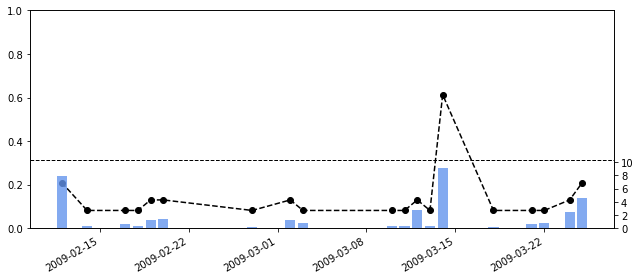

In [41]:
fig, ax = plt.subplots(figsize=(9,4))

ax1 = ax.twinx()
ax1.bar(pd.to_datetime(aus_ts.loc[plot_idx,'MeasDay']),
        aus_ts.loc[plot_idx,'MaxVal'],color='cornflowerblue',alpha=0.8)

ax.plot(pd.to_datetime(aus_ts.loc[plot_idx,'MeasDay']),
         aus_ts.loc[plot_idx,'Probs'],'--o',
         c='k',zorder=2)
ax.axhline(0.312,linewidth=1, color='k',linestyle='--')
ax.set_ylim(0,1)
ax.xaxis_date()
#ax.set_zorder(ax1.get_zorder() + 1)
ax1.set_ylim(0,33)
ax1.set_yticks([0,2,4,6,8,10])

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.tight_layout()
#fig.savefig('aus_sample_ts.png',dpi=400)